# Gradient Boosting

## Prerequisites

In [1]:
# Helper packages
import numpy as np
import pandas as pd
from plotnine import *

# Modeling packages
import xgboost as xgb
from sklearn.model_selection import train_test_split
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import partial_dependence
from sklearn.pipeline import Pipeline

In [2]:
# Ames housing data
ames = pd.read_csv("../data/ames.csv")

# create train/test split
train, test = train_test_split(ames, train_size=0.7, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop("Sale_Price", axis=1)
y_train = train[["Sale_Price"]]

## Basic GBM

In [4]:
# Ordinal encode our quality-based features 
ord_cols = list(X_train.filter(regex=("Qual$|QC$|Cond$")).columns)
lvs = ["Very_Poor", "Poor", "Fair", "Below_Average", "Average", "Typical", 
       "Above_Average", "Good", "Very_Good", "Excellent", "Very_Excellent"]
val = range(0, len(lvs))
lvl_map = dict(zip(lvs, val))
category_mapping = [{'col': col, 'mapping': lvl_map} for col in ord_cols]
ord_encoder = OrdinalEncoder(cols=ord_cols, mapping=category_mapping)

# one hot encode remaining nominal features
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# combine into a pre-processing pipeline
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
   ("ord_encode", ord_encoder, ord_cols),
   ("one-hot", encoder, selector(dtype_include="object")),
   ]
  )

In [5]:
# create random forest estimator
xgb_mod = xgb.XGBRegressor()

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgb_mod", xgb_mod),
])

# define loss function
loss = 'neg_root_mean_squared_error'

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# fit model with 5-fold CV
results = cross_val_score(model_pipeline, X_train, y_train, cv=kfold, scoring=loss)

np.abs(np.mean(results))

/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/Users/b294776/Desktop/Workspace/Project

25670.99931790421

## Basic GBM grid search

In [21]:
# define hyperparameters
hyper_grid = {
  'xgb_mod__n_estimators': [1000, 2500, 5000],
  'xgb_mod__learning_rate': [0.001, 0.01, 0.1],
  'xgb_mod__max_depth': [3, 5, 7, 9],
  'xgb_mod__min_child_weight': [1, 5, 15] 
}

In [24]:
random_search = RandomizedSearchCV(
    model_pipeline, 
    param_distributions=hyper_grid, 
    n_iter=20, 
    cv=kfold, 
    scoring=loss, 
    n_jobs=-1, 
    random_state=13
)

In [26]:
%%time
random_search_results = random_search.fit(X_train, y_train)

/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is 

CPU times: user 4min 24s, sys: 4.77 s, total: 4min 28s
Wall time: 1h 54min 26s


/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is 

In [27]:
# best model score
np.abs(random_search_results.best_score_)

22881.028505504495

In [28]:
random_search_results.best_params_

{'xgb_mod__n_estimators': 5000,
 'xgb_mod__min_child_weight': 1,
 'xgb_mod__max_depth': 3,
 'xgb_mod__learning_rate': 0.1}

## Stochastic GBMs

In [46]:
# create stochastic GBM estimator
xgb_mod = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1
)

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgb_mod", xgb_mod),
])

In [47]:
# define stochastic hyperparameters
stochastic_hyper_grid = {
  'xgb_mod__subsample': [0.5, 0.75, 1],
  'xgb_mod__colsample_bytree': [0.5, 0.75, 1],
  'xgb_mod__colsample_bylevel': [0.5, 0.75, 1],
  'xgb_mod__colsample_bynode': [0.5, 0.75, 1]
}

stochastic_random_search = RandomizedSearchCV(
    model_pipeline, 
    param_distributions=stochastic_hyper_grid, 
    n_iter=20, 
    cv=kfold, 
    scoring=loss, 
    n_jobs=-1, 
    random_state=13
)

In [48]:
%%time
stochastic_random_search_results = stochastic_random_search.fit(X_train, y_train)

/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


CPU times: user 2min 19s, sys: 2.87 s, total: 2min 22s
Wall time: 25min 5s


/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is 

In [49]:
# best model score
np.abs(stochastic_random_search_results.best_score_)

21990.50340555188

In [50]:
stochastic_random_search_results.best_params_

{'xgb_mod__subsample': 1,
 'xgb_mod__colsample_bytree': 0.75,
 'xgb_mod__colsample_bynode': 0.75,
 'xgb_mod__colsample_bylevel': 0.75}

## Regularized GBMs

In [54]:
# create stochastic GBM estimator
xgb_mod = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=0.75,
    colsample_bylevel=0.75,
    colsample_bynode=0.75
)

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgb_mod", xgb_mod),
])

In [55]:
# define regularization hyperparameters
regularization_hyper_grid = {
  'xgb_mod__gamma': [0, 0.1, 10, 1000],
  'xgb_mod__alpha': [0, 0.1, 10, 1000],
  'xgb_mod__lambda': [0, 0.1, 10, 1000]
}

regularization_random_search = RandomizedSearchCV(
    model_pipeline, 
    param_distributions=regularization_hyper_grid, 
    n_iter=20, 
    cv=kfold, 
    scoring=loss, 
    n_jobs=-1, 
    random_state=13
)

In [56]:
%%time
regularization_random_search_results = regularization_random_search.fit(X_train, y_train)

/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


CPU times: user 2min 19s, sys: 2.9 s, total: 2min 22s
Wall time: 23min 57s


/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is 

In [57]:
np.abs(regularization_random_search_results.best_score_)

22488.72653394142

## Tuning strategy

In [69]:
# create final GBM estimator
xgb_mod = xgb.XGBRegressor(
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=0.75,
    colsample_bylevel=0.75,
    colsample_bynode=0.75
)

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgb_mod", xgb_mod),
])

In [70]:
# define hyperparameters
hyper_grid = {'xgb_mod__n_estimators': [2000, 3000, 4000, 5000, 6000, 7000, 8000]}

final_search = GridSearchCV(
    model_pipeline, 
    hyper_grid, 
    cv=kfold, 
    scoring=loss, 
    n_jobs=-1
)

In [71]:
%%time
final_search_results = final_search.fit(X_train, y_train)

/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


CPU times: user 47.5 s, sys: 686 ms, total: 48.2 s
Wall time: 9min 5s


In [72]:
np.abs(final_search_results.best_score_)

21948.509842280964

In [73]:
final_search_results.best_params_

{'xgb_mod__n_estimators': 2000}

/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is 

## Feature importance

/Users/b294776/Desktop/Workspace/Projects/misk/misk-homl/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


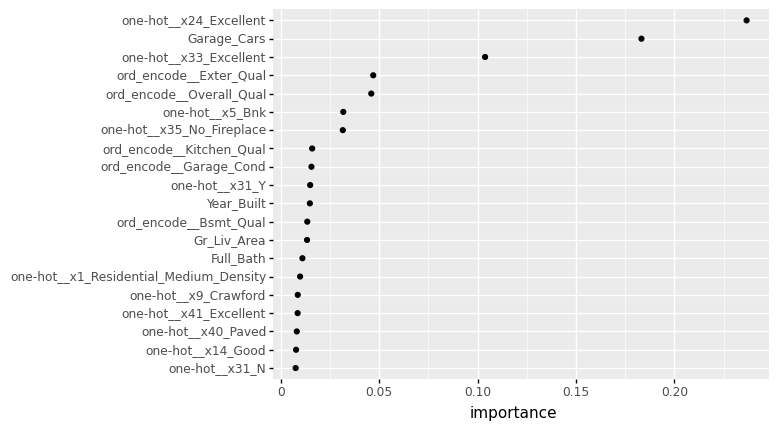

<ggplot: (321934674)>

In [75]:
# preprocess training data
X_encoded = preprocessor.fit_transform(X_train)

# create final model object
final_model = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=0.75,
    colsample_bylevel=0.75,
    colsample_bynode=0.75
)

final_model_fit = final_model.fit(X_encoded, y_train)

# extract feature importances
vi = pd.DataFrame({'feature': preprocessor.get_feature_names(),
                   'importance': final_model_fit.feature_importances_})

# get top 20 influential features
top_20_features = vi.nlargest(20, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))

## Exercises

Using the Boston housing data set, where the response feature is the median value of homes within a census tract (`cmedv`):

1. Apply a basic GBM model with the same features you used in the random forest module. 
   - Apply the default hyperparameter settings with a learning rate set to 0.10. How does model performance compare to the random forest module?
   - How many trees were applied? Was this enough to stabilize the loss function or do you need to add more?
   - Tune the tree-based hyperparameters described for basic GBMs. Did your model performance improve?
2. Apply a stochastic GBM model. Tune the hyperparameters using the suggested tuning strategy for stochastic GBMs. Did your model performance improve?
3. Apply regularization to your XGBoost model. Did regularization improve performance?
4. Pick your best GBM model. Which 10 features are considered most influential? Are these the same features that have been influential in previous models?
5. Create partial dependence plots for the top two most influential features. Explain the relationship between the feature and the predicted values.
6. Now perform 1-5 to the Attrition dataset, which is classification model rather than a regression model.